Alzheimers Prediction Model using CNN

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

Defining the Directory Path and iterating through subfloders of said Directory to create the data-frame(df) 

In [2]:
dataset_path = 'C:\\Users\\Krishang Virmani\\Desktop\\Python CB\\ADNI\\Alzheimer_s Dataset'

images = []
labels = []


for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    
    
    if os.path.isdir(subfolder_path):
        
        for folder in os.listdir(subfolder_path):
            folder_path = os.path.join(subfolder_path, folder)
            
            
            if os.path.isdir(folder_path):
                
                for image_filename in os.listdir(folder_path):
                   
                    if image_filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        image_path = os.path.join(folder_path, image_filename)
                        images.append(image_path)
                        labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})


In [3]:
df

image             label
0     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
1     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
2     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
3     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
4     C:\Users\Krishang Virmani\Desktop\Python CB\AD...      MildDemented
...                                                 ...               ...
6395  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6396  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6397  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6398  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented
6399  C:\Users\Krishang Virmani\Desktop\Python CB\AD...  VeryMildDemented

[6400 rows x 2 columns]

Visualizing Number of samples in each of the classes

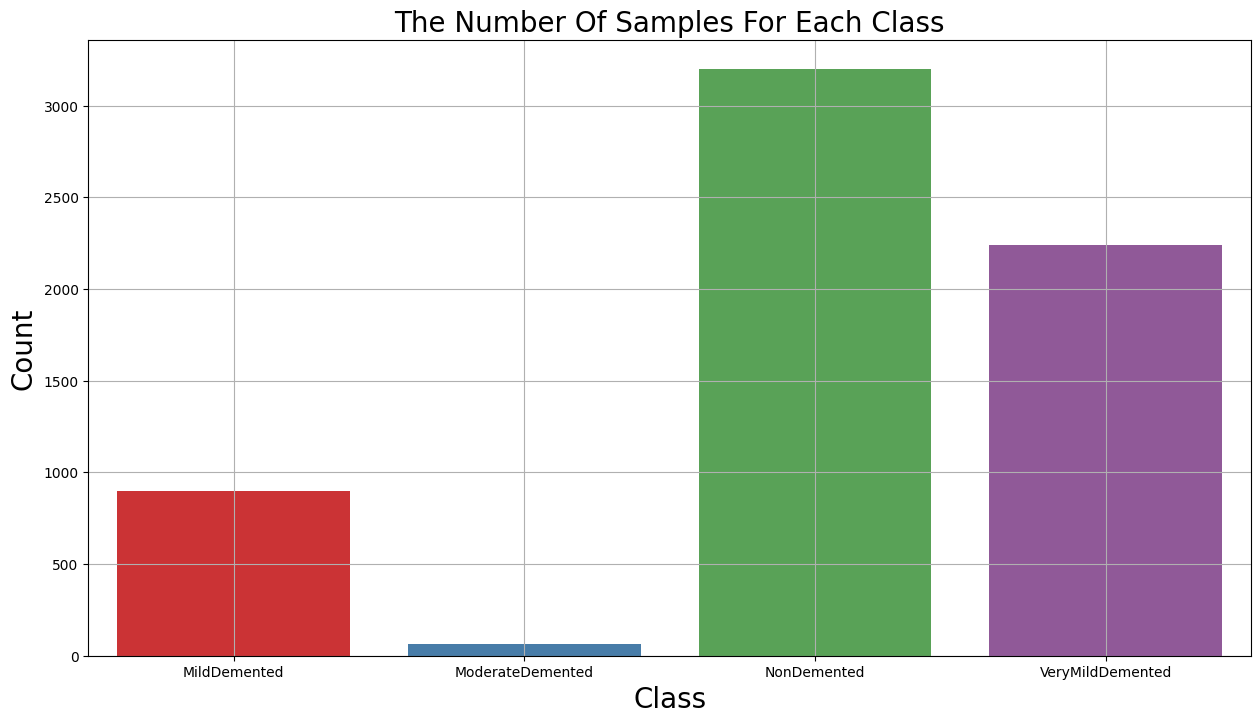

In [4]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1',hue=df.label,legend=False)
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.show()

Random Images from the Dataset including their Labels

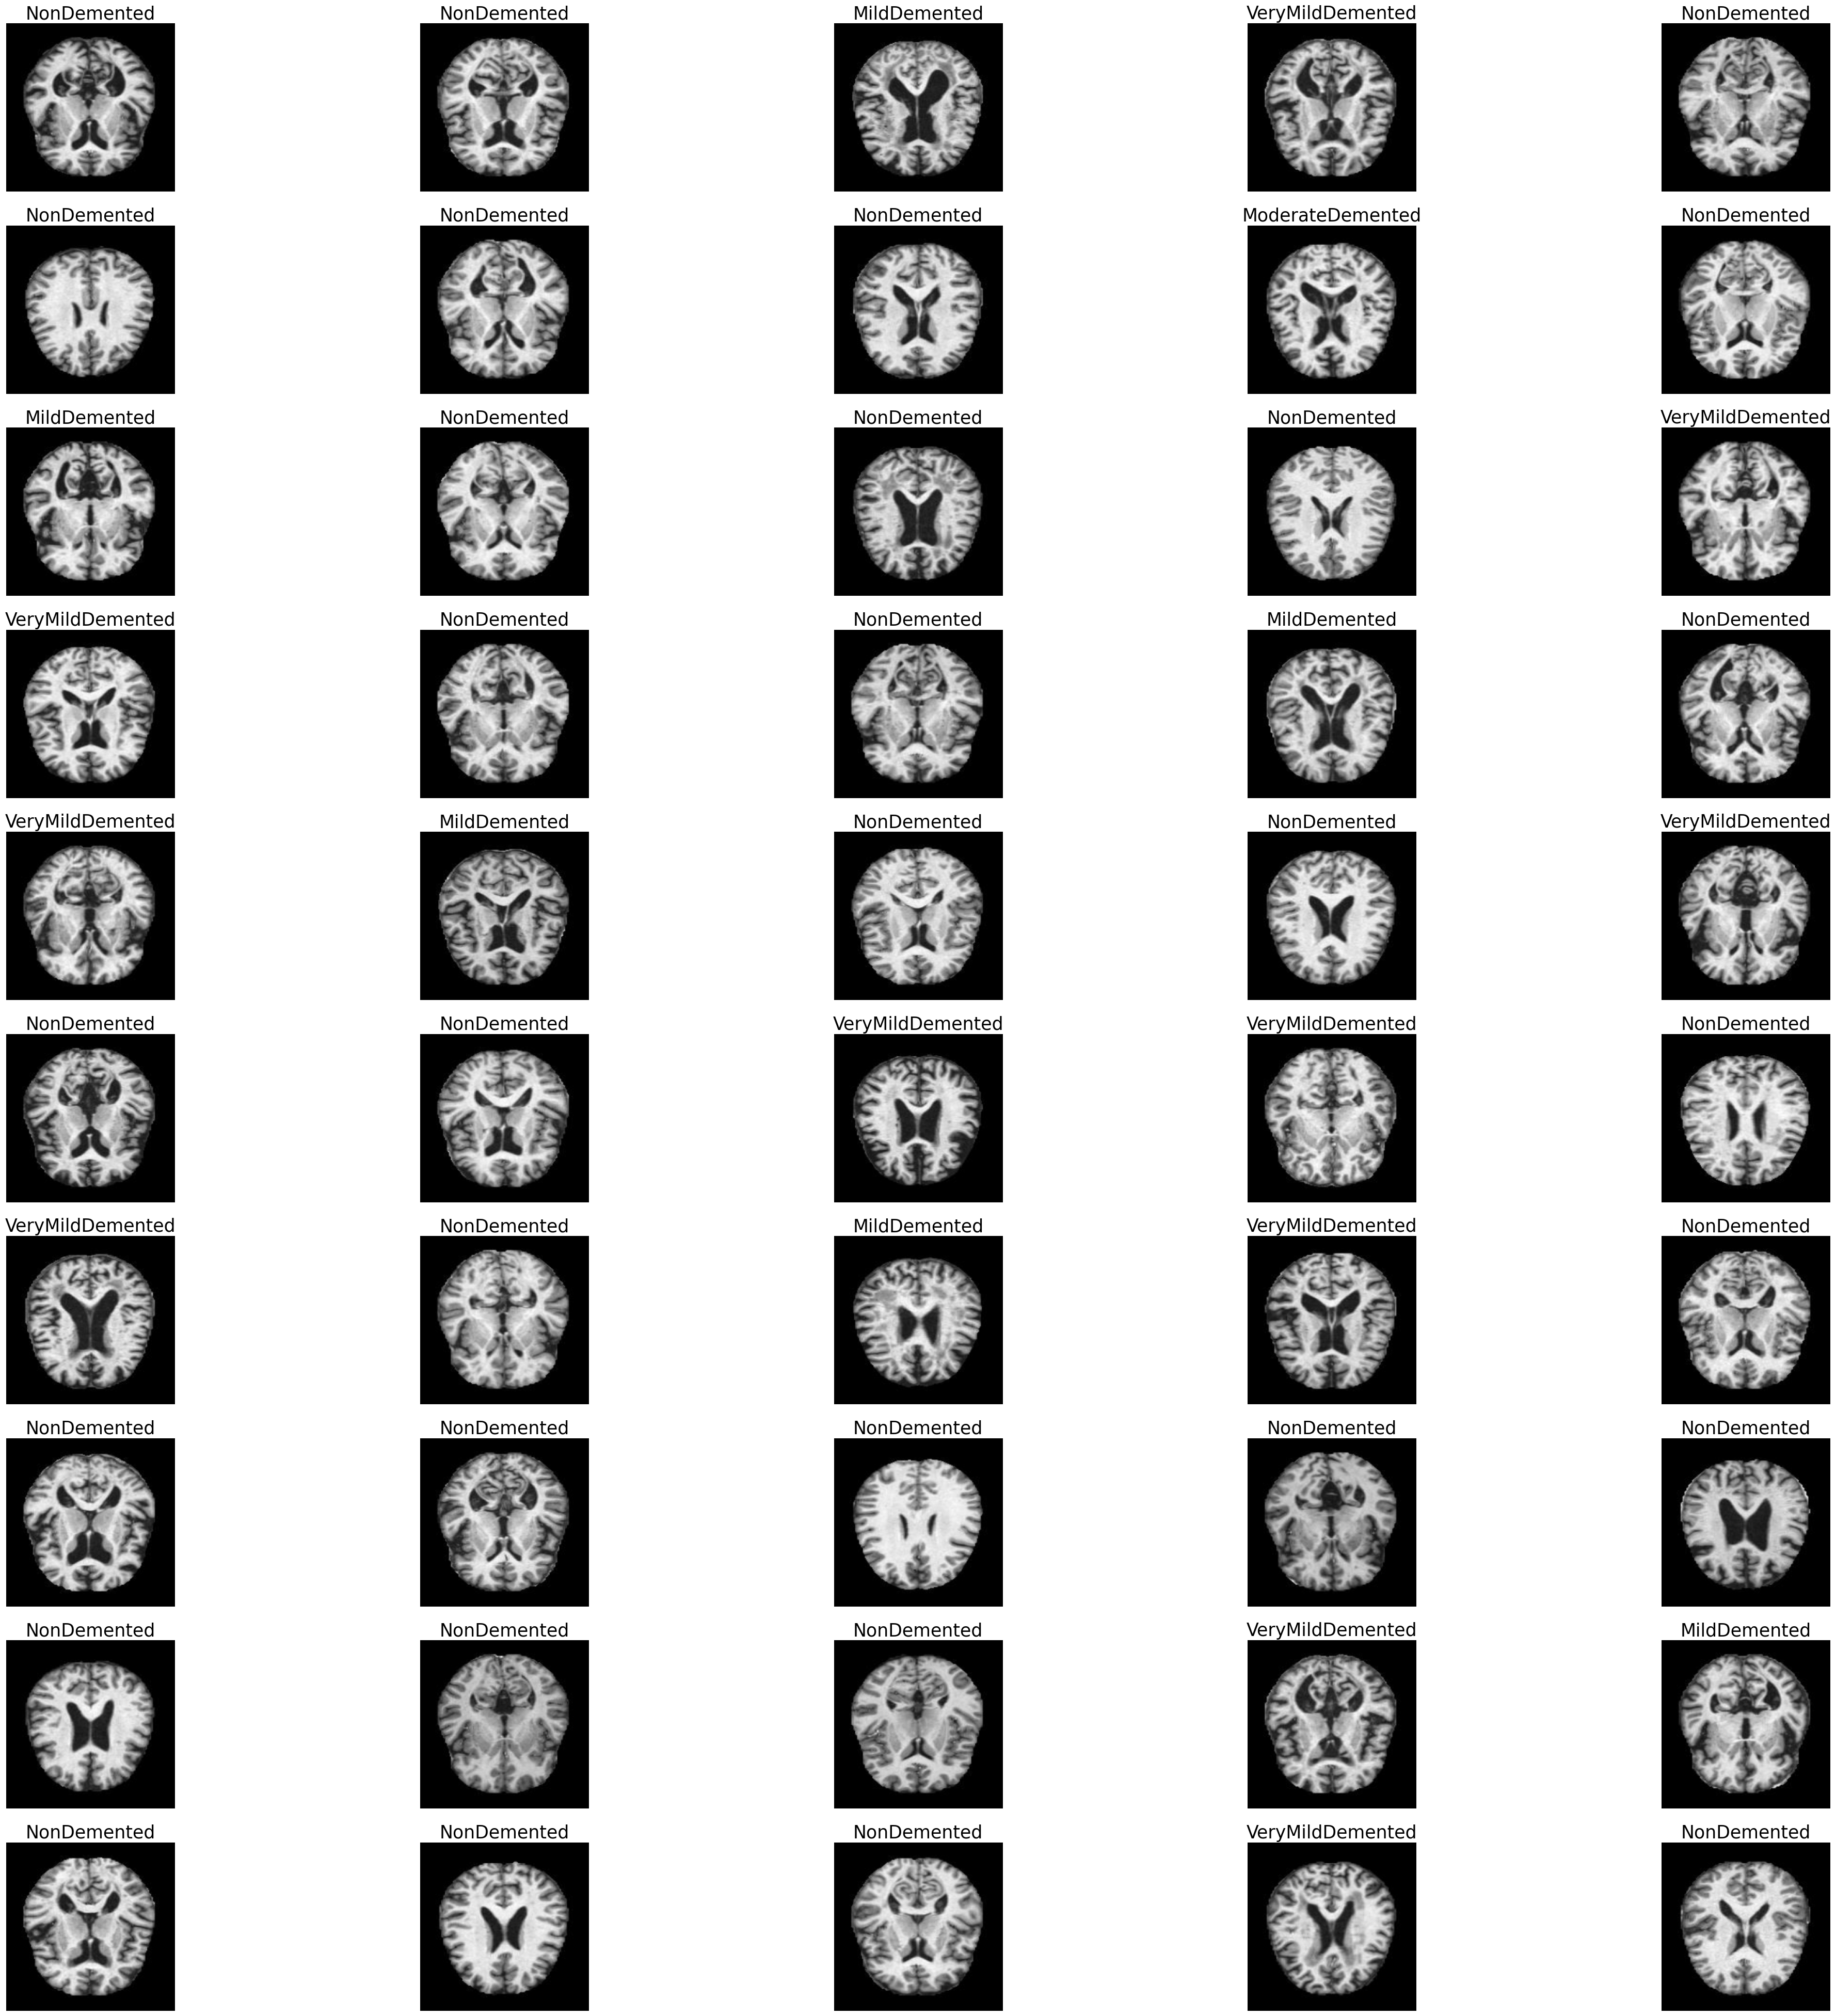

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

Setting up a data generator for training data from a DataFrame, resizing the images, and rescaling the pixel values

In [6]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [7]:
train_data, train_labels = train_data_gen.next()

In [8]:
class_num=np.sort(['Alzheimer_s disease','Cognitively normal','Early mild cognitive impairment','Late mild cognitive impairment'])


In [9]:
class_num

array(['Alzheimer_s disease', 'Cognitively normal',
       'Early mild cognitive impairment',
       'Late mild cognitive impairment'], dtype='<U31')

Addressing class imbalance in the training data using SMOTE (Synthetic Minority Over-sampling Technique) 

In [10]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


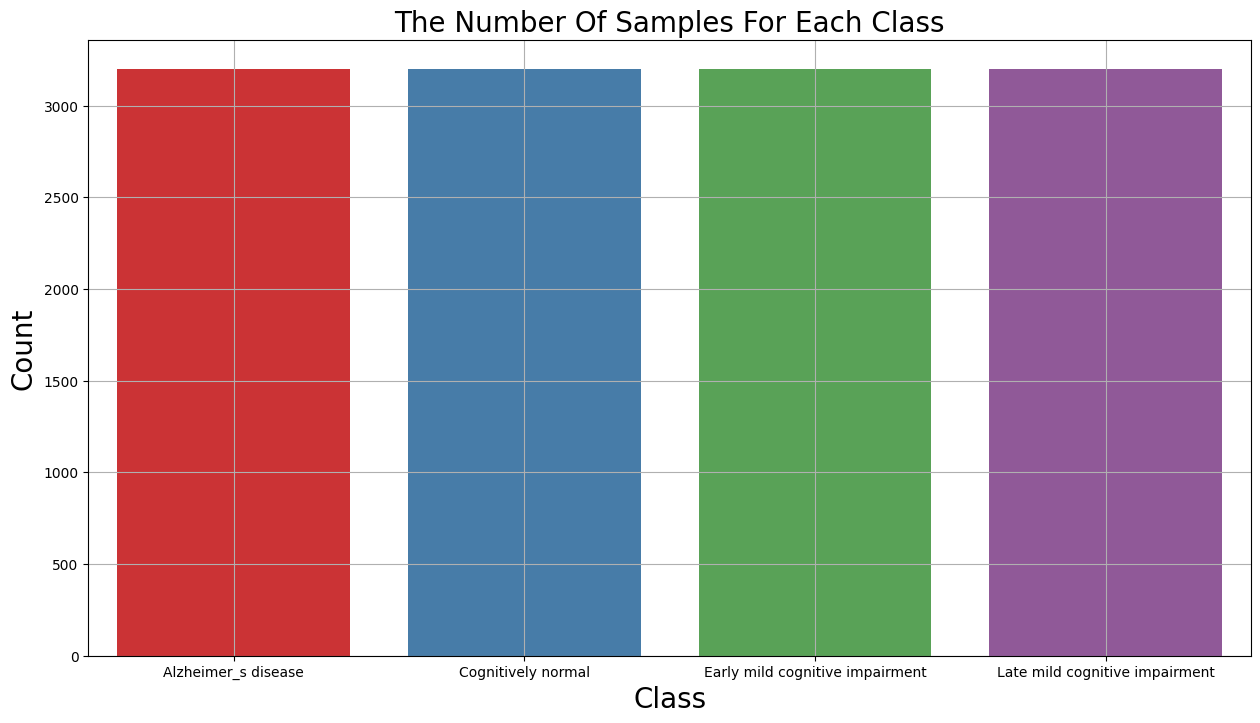

In [11]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1' ,hue=labels,legend=False)
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.show()

Splitting the data into training, validation, and test sets while ensuring that the class distribution is maintained in each split using Stratify

In [12]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


Defining the CNN model Architecture

In [13]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 44, 44, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 128)         0

Here we get a plot of the model for better understanding

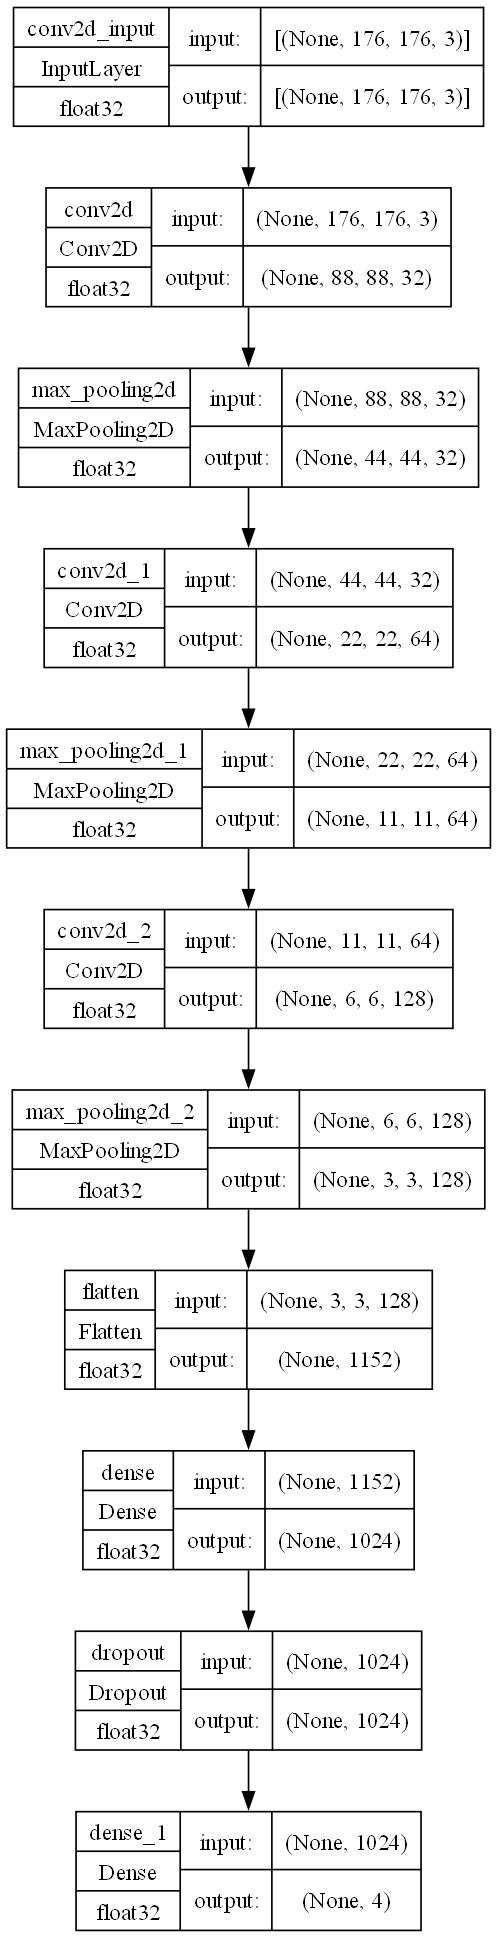

In [15]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

Saving the model into a HDF5 file for future use , and Fitting the model for the X_test

In [16]:
checkpoint_cb =ModelCheckpoint("CNN_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
280/280 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.5900

C:\Users\Krishang Virmani\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 25s 81ms/step - loss: 0.8697 - accuracy: 0.5900 - val_loss: 0.5746 - val_accuracy: 0.7526
Epoch 2/50
280/280 [==============================] - 19s 68ms/step - loss: 0.4488 - accuracy: 0.8036 - val_loss: 0.3313 - val_accuracy: 0.8635
Epoch 3/50
280/280 [==============================] - 19s 67ms/step - loss: 0.2574 - accuracy: 0.8915 - val_loss: 0.2349 - val_accuracy: 0.8958
Epoch 4/50
280/280 [==============================] - 15s 55ms/step - loss: 0.1436 - accuracy: 0.9468 - val_loss: 0.1480 - val_accuracy: 0.9422
Epoch 5/50
280/280 [==============================] - 15s 54ms/step - loss: 0.0931 - accuracy: 0.9640 - val_loss: 0.1648 - val_accuracy: 0.9375
Epoch 6/50
280/280 [==============================] - 15s 55ms/step - loss: 0.0771 - accuracy: 0.9723 - val_loss: 0.1066 - val_accuracy: 0.9599
Epoch 7/50
280/280 [==============================] - 15s 53ms/step - loss: 0.0433 - accuracy: 0.9854 - val_loss: 0.1367 - val_accuracy: 0.9427
Epo

In [18]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   0.869716  0.589955  0.574613      0.752604
1   0.448813  0.803571  0.331326      0.863542
2   0.257420  0.891518  0.234886      0.895833
3   0.143565  0.946763  0.148048      0.942187
4   0.093093  0.963951  0.164823      0.937500
5   0.077115  0.972321  0.106563      0.959896
6   0.043308  0.985379  0.136674      0.942708
7   0.038286  0.986942  0.085894      0.972917
8   0.022550  0.992522  0.143217      0.955729
9   0.008694  0.997433  0.095182      0.968750
10  0.053944  0.983371  0.123050      0.959896
11  0.035741  0.987723  0.148688      0.955208
12  0.035323  0.988170  0.109051      0.961458
13  0.011081  0.996205  0.088076      0.976042
14  0.023479  0.991518  0.110548      0.969792
15  0.021459  0.991629  0.074178      0.978646
16  0.020118  0.993080  0.143034      0.960938
17  0.035125  0.987946  0.073304      0.976562
18  0.023154  0.992522  0.318668      0.910937
19  0.018386  0.994531  0.094451      0.977083
20  0.015030  0.995313  0.087789      0.976562
21  0.024013  0.992076  0.074286      0.981250
22  0.019773  0.993304  0.099969      0.970312
23  0.012641  0.995536  0.102687      0.972917
24  0.022745  0.991853  0.133474      0.971875
25  0.018791  0.993638  0.086945      0.975521
26  0.005626  0.997991  0.136140      0.973958
27  0.026214  0.991629  0.337992      0.928125

Plotting the Accuracy and Loss Graphs 

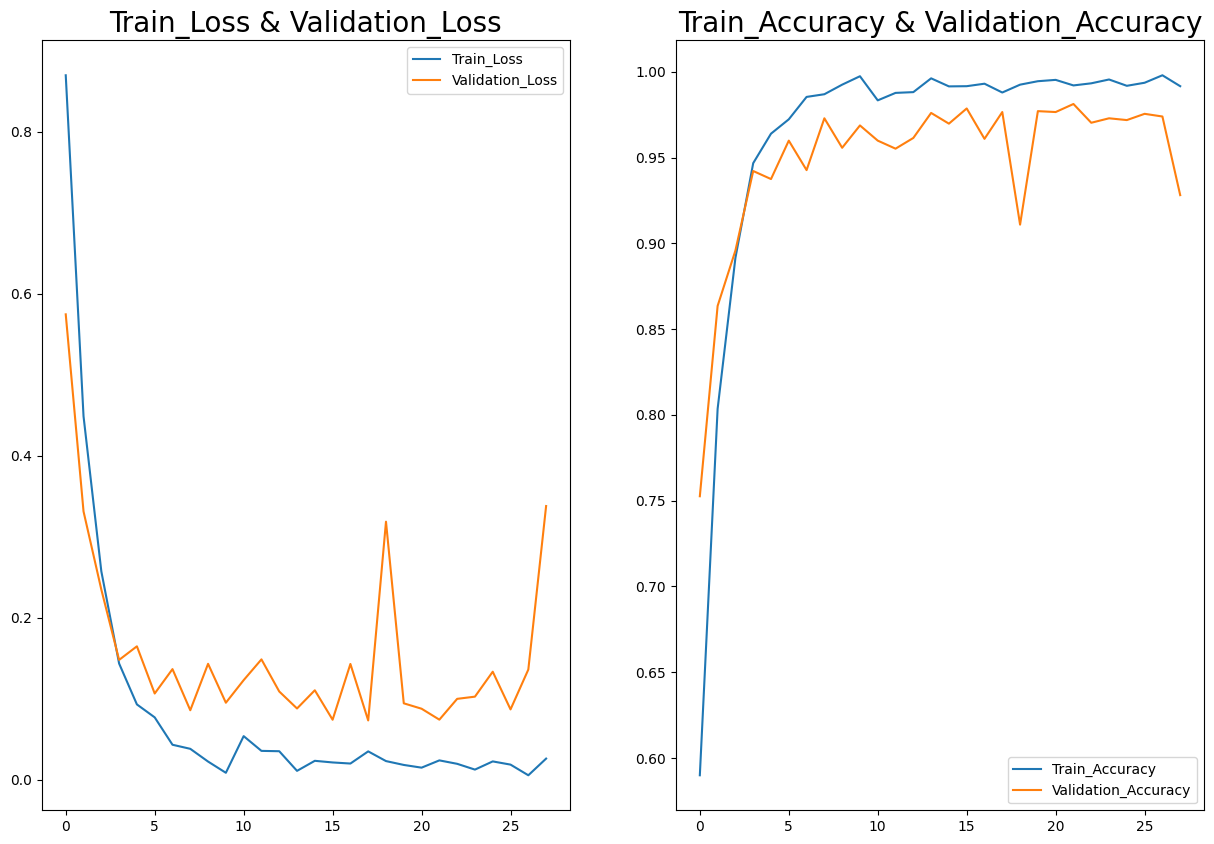

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

Evaluating the model

In [20]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 1s 18ms/step - loss: 0.0721 - accuracy: 0.9776
Test Loss = 0.07208163291215897
Test Accuracy = 0.9776041507720947


In [21]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 1s 18ms/step


Actual  Prediction
0          1           1
1          1           1
2          0           3
3          2           2
4          2           2
...      ...         ...
1915       2           2
1916       0           3
1917       2           2
1918       3           3
1919       3           3

[1920 rows x 2 columns]

Brain Images along with the predicted labels and the Actual labels

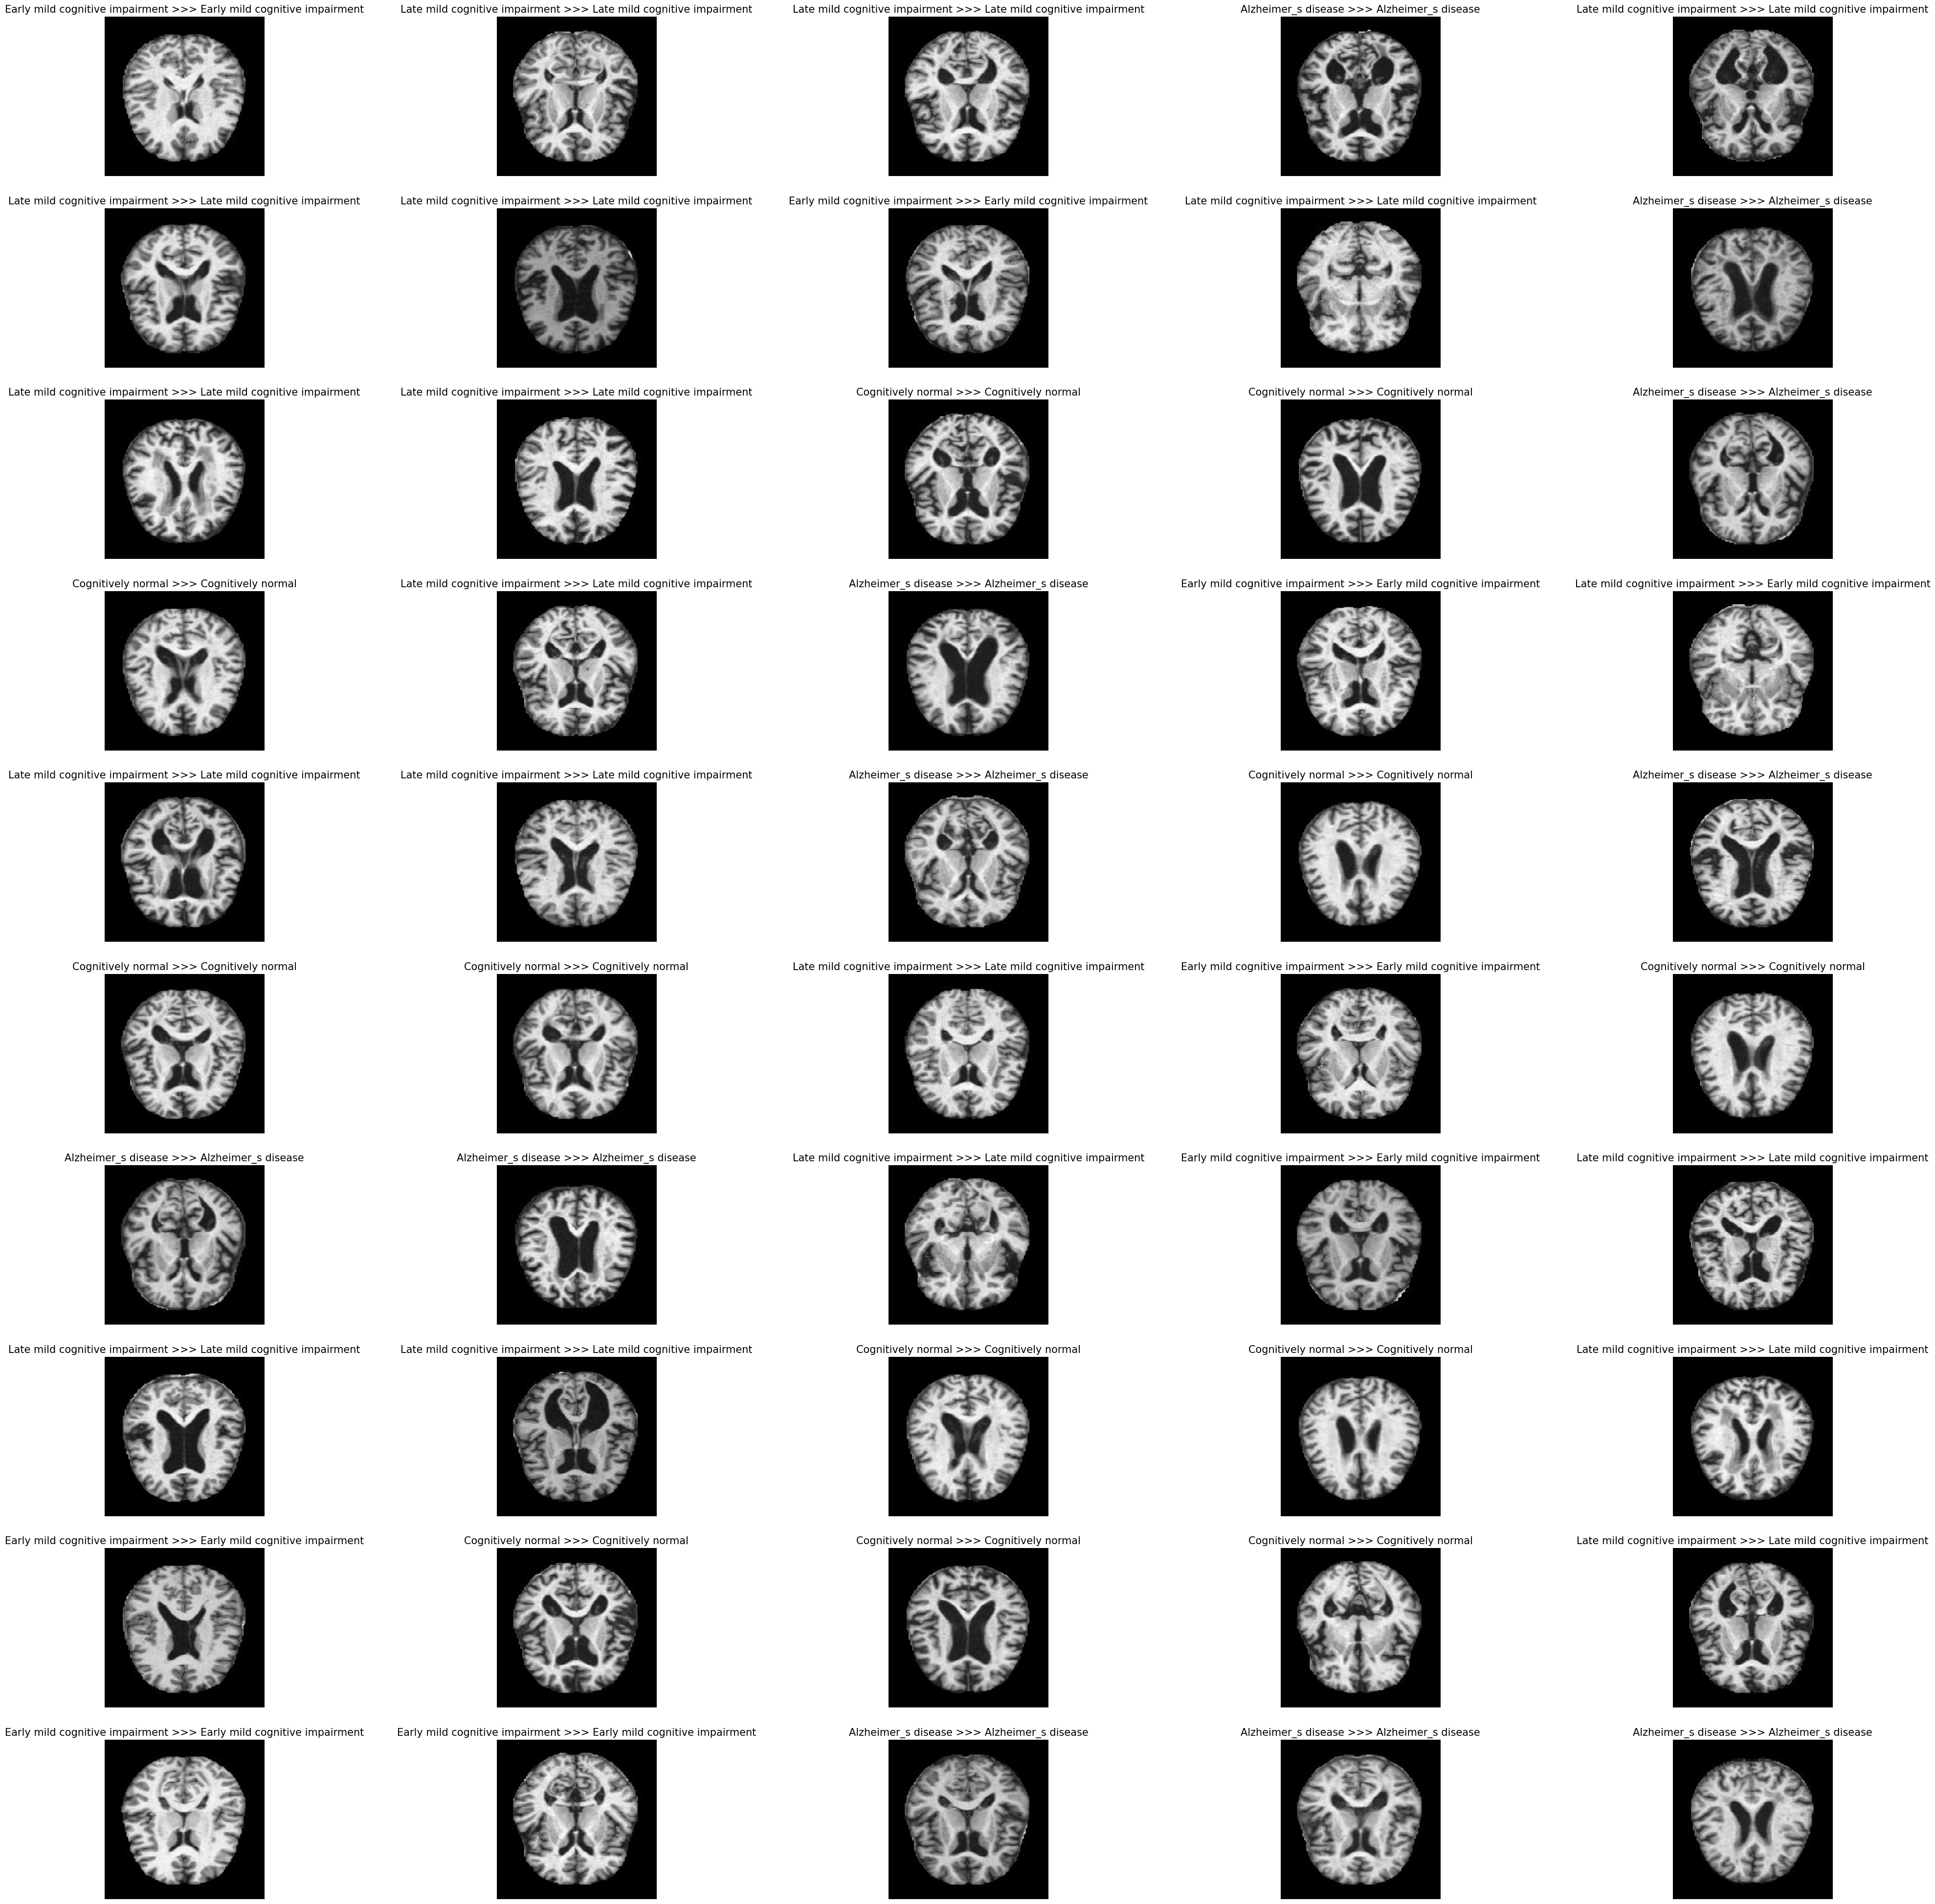

In [22]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

Confusion matrix to help us visualize the Strength and Weakness of a model in terms of which class it can classify 

array([[464,   0,   9,   7],
       [  0, 480,   0,   0],
       [  1,   0, 473,   6],
       [  4,   0,  16, 460]], dtype=int64)

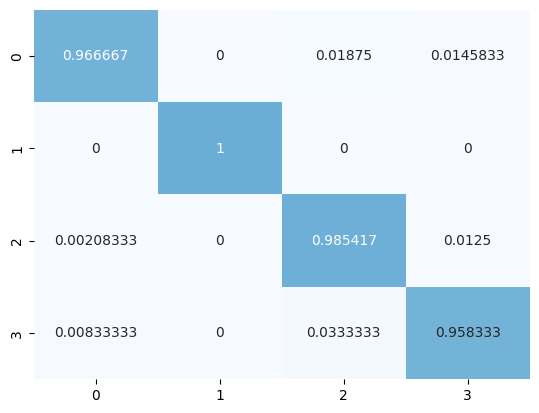

In [23]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [24]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is :\n')
print(ClassificationReport )

Classification Report is :

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       480
           1       1.00      1.00      1.00       480
           2       0.95      0.99      0.97       480
           3       0.97      0.96      0.97       480

    accuracy                           0.98      1920
   macro avg       0.98      0.98      0.98      1920
weighted avg       0.98      0.98      0.98      1920

